In [35]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from flask import Flask, request, jsonify
from PIL import Image

In [36]:
# Dataset Paths
data_dir = r"C:\Users\eyaya\Downloads\ChestXRay2017\chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [37]:

# Data Augmentation
img_size = (224, 224)
batch_size = 32

data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = data_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', subset='training')
valid_gen = data_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', subset='validation')




Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [38]:
# Model Architecture
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [39]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [40]:
# Training
epochs = 15
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.8219 - loss: 0.3785 - val_accuracy: 0.7426 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8893 - loss: 0.2721 - val_accuracy: 0.8249 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8952 - loss: 0.2600 - val_accuracy: 0.8249 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9043 - loss: 0.2373 - val_accuracy: 0.9110 - val_loss: 0.2624 - learning_rate: 0.0010
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9015 - loss: 0.2413 - val_accuracy: 0.9244 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9113 - loss: 0.2156 - val_accuracy: 0.9234 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9132 - loss: 0.

In [41]:
# Save Model
model.save("chest_xray_model.h5")


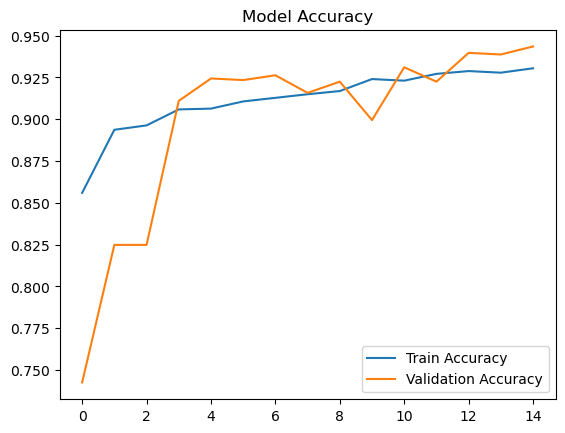

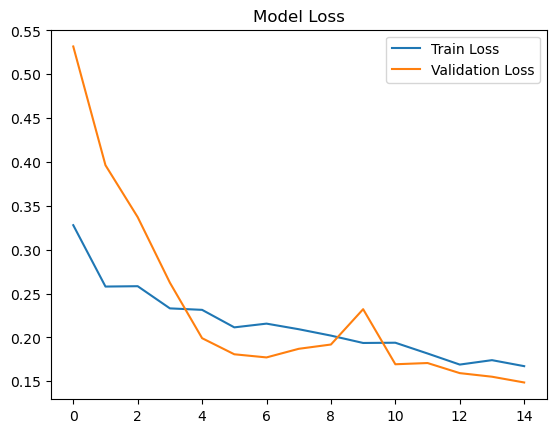

In [42]:

# Evaluation Plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()